## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

/home/pratik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [5]:
path = '/home/pratik/Desktop/flight_price_sagemaker/data/train.csv'

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-09,Delhi,Cochin,00:20:00,07:40:00,440,1.0,In-flight meal not included,13977
1,Jet Airways,2019-05-24,Kolkata,Banglore,20:25:00,09:45:00,800,1.0,In-flight meal not included,12384
2,Jet Airways,2019-05-09,Delhi,Cochin,18:15:00,04:25:00,610,1.0,In-flight meal not included,12373
3,Multiple Carriers,2019-06-01,Delhi,Cochin,10:00:00,01:30:00,930,1.0,No info,7198
4,Jet Airways,2019-06-01,Delhi,Cochin,21:50:00,12:35:00,885,1.0,In-flight meal not included,10262
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-15,Banglore,New Delhi,11:40:00,18:25:00,405,1.0,In-flight meal not included,9134
636,Jet Airways,2019-06-15,Delhi,Cochin,09:35:00,12:35:00,1620,2.0,In-flight meal not included,10824
637,Multiple Carriers,2019-06-12,Delhi,Cochin,04:55:00,12:35:00,460,1.0,No info,10678
638,Jet Airways,2019-05-18,Kolkata,Banglore,05:45:00,09:20:00,1655,1.0,In-flight meal not included,9663


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      639 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [8]:
X_train.airline

0      Multiple Carriers
1            Jet Airways
2            Jet Airways
3      Multiple Carriers
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,0.0,1.0,0.0
638,0.0,0.0,1.0,0.0,0.0


### 4.2 date_of_journey

In [10]:
X_train.date_of_journey

0      2019-03-09
1      2019-05-24
2      2019-05-09
3      2019-06-01
4      2019-06-01
          ...    
635    2019-03-15
636    2019-06-15
637    2019-06-12
638    2019-05-18
639    2019-05-18
Name: date_of_journey, Length: 640, dtype: object

In [11]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.833333,0.067797
1,0.666667,0.705882,0.666667,0.711864
2,0.666667,0.588235,0.500000,0.584746
3,1.000000,0.764706,0.833333,0.779661
4,1.000000,0.764706,0.833333,0.779661
...,...,...,...,...
635,0.000000,0.117647,0.666667,0.118644
636,1.000000,0.882353,0.833333,0.898305
637,1.000000,0.882353,0.333333,0.872881
638,0.666667,0.647059,0.833333,0.661017


### 4.3 source & destination

In [12]:
X_train.source

0         Delhi
1       Kolkata
2         Delhi
3         Delhi
4         Delhi
         ...   
635    Banglore
636       Delhi
637       Delhi
638     Kolkata
639       Delhi
Name: source, Length: 640, dtype: object

In [13]:
X_train.destination

0         Cochin
1       Banglore
2         Cochin
3         Cochin
4         Cochin
         ...    
635    New Delhi
636       Cochin
637       Cochin
638     Banglore
639       Cochin
Name: destination, Length: 640, dtype: object

In [14]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Banglore,New Delhi
636,Delhi,Cochin
637,Delhi,Cochin
638,Kolkata,Banglore


In [15]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.085195,1.030858
1,-0.547373,-0.620435
2,1.085195,1.030858
3,1.085195,1.030858
4,1.085195,1.030858
...,...,...
635,-0.504923,-0.074898
636,1.085195,1.030858
637,1.085195,1.030858
638,-0.547373,-0.620435


In [16]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,1,0
638,1,0


In [18]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.085195,1.030858,1,0
1,-0.547373,-0.620435,1,0
2,1.085195,1.030858,1,0
3,1.085195,1.030858,1,0
4,1.085195,1.030858,1,0
...,...,...,...,...
635,-0.504923,-0.074898,0,1
636,1.085195,1.030858,1,0
637,1.085195,1.030858,1,0
638,-0.547373,-0.620435,1,0


### 4.4 dep_time & arrival_time

In [19]:
X_train.dep_time

0      00:20:00
1      20:25:00
2      18:15:00
3      10:00:00
4      21:50:00
         ...   
635    11:40:00
636    09:35:00
637    04:55:00
638    05:45:00
639    05:30:00
Name: dep_time, Length: 640, dtype: object

In [20]:
X_train.arrival_time

0      07:40:00
1      09:45:00
2      04:25:00
3      01:30:00
4      12:35:00
         ...   
635    18:25:00
636    12:35:00
637    12:35:00
638    09:20:00
639    12:35:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,00:20:00,07:40:00
1,20:25:00,09:45:00
2,18:15:00,04:25:00
3,10:00:00,01:30:00
4,21:50:00,12:35:00
...,...,...
635,11:40:00,18:25:00
636,09:35:00,12:35:00
637,04:55:00,12:35:00
638,05:45:00,09:20:00


In [22]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.000000,0.363636,0.304348,0.727273
1,0.869565,0.454545,0.391304,0.818182
2,0.782609,0.272727,0.173913,0.454545
3,0.434783,0.000000,0.043478,0.545455
4,0.913043,0.909091,0.521739,0.636364
...,...,...,...,...
635,0.478261,0.727273,0.782609,0.454545
636,0.391304,0.636364,0.521739,0.636364
637,0.173913,1.000000,0.521739,0.636364
638,0.217391,0.818182,0.391304,0.363636


In [23]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,morning
1,night,morning
2,evening,morning
3,morning,night
4,night,afternoon
...,...,...
635,morning,evening
636,morning,afternoon
637,morning,afternoon
638,morning,morning


In [24]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.068376,1.000000
1,0.068376,1.000000
2,0.196581,1.000000
3,1.000000,0.942529
4,0.068376,0.000000
...,...,...
635,1.000000,0.724138
636,1.000000,0.000000
637,1.000000,0.000000
638,1.000000,1.000000


In [25]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.363636,0.304348,0.727273,0.068376,1.000000
1,0.869565,0.454545,0.391304,0.818182,0.068376,1.000000
2,0.782609,0.272727,0.173913,0.454545,0.196581,1.000000
3,0.434783,0.000000,0.043478,0.545455,1.000000,0.942529
4,0.913043,0.909091,0.521739,0.636364,0.068376,0.000000
...,...,...,...,...,...,...
635,0.478261,0.727273,0.782609,0.454545,1.000000,0.724138
636,0.391304,0.636364,0.521739,0.636364,1.000000,0.000000
637,0.173913,1.000000,0.521739,0.636364,1.000000,0.000000
638,0.217391,0.818182,0.391304,0.363636,1.000000,1.000000


### 4.5 duration

In [47]:
X_train.duration

0       440
1       800
2       610
3       930
4       885
       ... 
635     405
636    1620
637     460
638    1655
639     425
Name: duration, Length: 640, dtype: int64

In [48]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.  ],
       [542.5 ],
       [961.25]])

In [66]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [67]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

ValueError: Input contains NaN.

In [68]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [69]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [71]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.361128,-0.096094,-0.088764,2.0,0,-0.442701
1,-0.361128,-0.096094,-0.088764,2.0,0,0.277795
2,-0.361128,-0.096094,-0.088764,2.0,0,-0.102467
3,-0.361128,-0.096094,-0.088764,2.0,0,0.537973
4,-0.361128,-0.096094,-0.088764,2.0,0,0.447911
...,...,...,...,...,...,...
635,-0.361128,-0.096094,-0.088764,2.0,0,-0.512749
636,-0.361128,-0.096094,-0.088764,2.0,1,1.918923
637,-0.361128,-0.096094,-0.088764,2.0,0,-0.402673
638,-0.361128,-0.096094,-0.088764,2.0,1,1.988971


### 4.6 total_stops

In [72]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    2.0
637    1.0
638    1.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [73]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,2.0,0
637,1.0,0
638,1.0,0


### 4.7 additional_info

In [74]:
X_train.additional_info

0      In-flight meal not included
1      In-flight meal not included
2      In-flight meal not included
3                          No info
4      In-flight meal not included
                  ...             
635    In-flight meal not included
636    In-flight meal not included
637                        No info
638    In-flight meal not included
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [75]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,1.0,0.0,0.0
637,0.0,1.0,0.0
638,1.0,0.0,0.0


In [76]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [77]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [78]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,1
4,1.0,0.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,1
638,1.0,0.0,0.0,1


### 4.8 Column Transformer

In [79]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,1.0,0.0,0.000000,0.058824,0.833333,0.067797,1.085195,1.030858,1,0,0.000000,0.363636,0.304348,0.727273,0.068376,1.000000,-0.361128,-0.096094,-0.088764,2.0,0,-0.442701,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.547373,-0.620435,1,0,0.869565,0.454545,0.391304,0.818182,0.068376,1.000000,-0.361128,-0.096094,-0.088764,2.0,0,0.277795,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,1.085195,1.030858,1,0,0.782609,0.272727,0.173913,0.454545,0.196581,1.000000,-0.361128,-0.096094,-0.088764,2.0,0,-0.102467,1.0,0,1.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,1.000000,0.764706,0.833333,0.779661,1.085195,1.030858,1,0,0.434783,0.000000,0.043478,0.545455,1.000000,0.942529,-0.361128,-0.096094,-0.088764,2.0,0,0.537973,1.0,0,0.0,1.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.085195,1.030858,1,0,0.913043,0.909091,0.521739,0.636364,0.068376,0.000000,-0.361128,-0.096094,-0.088764,2.0,0,0.447911,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.666667,0.118644,-0.504923,-0.074898,0,1,0.478261,0.727273,0.782609,0.454545,1.000000,0.724138,-0.361128,-0.096094,-0.088764,2.0,0,-0.512749,1.0,0,1.0,0.0,0.0,1
636,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,1.085195,1.030858,1,0,0.391304,0.636364,0.521739,0.636364,1.000000,0.000000,-0.361128,-0.096094,-0.088764,2.0,1,1.918923,2.0,0,1.0,0.0,0.0,1
637,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.333333,0.872881,1.085195,1.030858,1,0,0.173913,1.000000,0.521739,0.636364,1.000000,0.000000,-0.361128,-0.096094,-0.088764,2.0,0,-0.402673,1.0,0,0.0,1.0,0.0,1
638,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.547373,-0.620435,1,0,0.217391,0.818182,0.391304,0.363636,1.000000,1.000000,-0.361128,-0.096094,-0.088764,2.0,1,1.988971,1.0,0,1.0,0.0,0.0,1


## 5. Feature Selection

In [80]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [81]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_rbf_25,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.000000,0.058824,0.067797,-0.361128,2.0,-0.442701,1.0,0
1,0.0,1.0,0.666667,0.705882,0.711864,-0.361128,2.0,0.277795,1.0,0
2,0.0,1.0,0.666667,0.588235,0.584746,-0.361128,2.0,-0.102467,1.0,0
3,0.0,0.0,1.000000,0.764706,0.779661,-0.361128,2.0,0.537973,1.0,0
4,0.0,1.0,1.000000,0.764706,0.779661,-0.361128,2.0,0.447911,1.0,0
...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.000000,0.117647,0.118644,-0.361128,2.0,-0.512749,1.0,0
636,0.0,1.0,1.000000,0.882353,0.898305,-0.361128,2.0,1.918923,2.0,0
637,0.0,0.0,1.000000,0.882353,0.872881,-0.361128,2.0,-0.402673,1.0,0
638,0.0,1.0,0.666667,0.647059,0.661017,-0.361128,2.0,1.988971,1.0,0


## 7. Visualizations

In [82]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0030133761882390107,
 'air__airline_Indigo': 0.14391214174636804,
 'air__airline_Jet Airways': 0.18721180627030679,
 'air__airline_Multiple Carriers': 0.001996736381921401,
 'air__airline_Other': 0.0760839030976223,
 'doj__date_of_journey_month': 0.10712875733925564,
 'doj__date_of_journey_week': 0.20077658148952163,
 'doj__date_of_journey_day_of_week': 0.03806374507978446,
 'doj__date_of_journey_day_of_year': 0.2545675916520052,
 'location__source': 0.06299112149257413,
 'location__destination': 0.09852294866086009,
 'location__source_is_north': -0.01664310361873474,
 'location__destination_is_north': -0.01664310361873474,
 'time__dep_time_hour': 0.004232970677635395,
 'time__dep_time_minute': 0.010916717672525592,
 'time__arrival_time_hour': -0.0043782058070321135,
 'time__arrival_time_minute': -0.029237812527696565,
 'time__dep_time_part_of_day': -0.013680284294286324,
 'time__arrival_time_part_of_day': 0.013318004458271618,
 'dur__duration_rbf_25': 0.1

In [83]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__arrival_time_minute': -0.029237812527696565,
 'info__additional_info_Other': -0.02129202252085845,
 'location__source_is_north': -0.01664310361873474,
 'location__destination_is_north': -0.01664310361873474,
 'time__dep_time_part_of_day': -0.013680284294286324,
 'info__additional_info_No info': -0.012052532814053274,
 'dur__duration_rbf_50': -0.008946809421515045,
 'info__additional_info_In-flight meal not included': -0.006203103685348858,
 'dur__duration_rbf_75': -0.005827204671708053,
 'info__additional_info': -0.004879730219697305,
 'time__arrival_time_hour': -0.0043782058070321135,
 'air__airline_Air India': -0.0030133761882390107,
 'air__airline_Multiple Carriers': 0.001996736381921401,
 'time__dep_time_hour': 0.004232970677635395,
 'time__dep_time_minute': 0.010916717672525592,
 'time__arrival_time_part_of_day': 0.013318004458271618,
 'doj__date_of_journey_day_of_week': 0.03806374507978446,
 'location__source': 0.06299112149257413,
 'air__airline_Other': 0.076083903097622

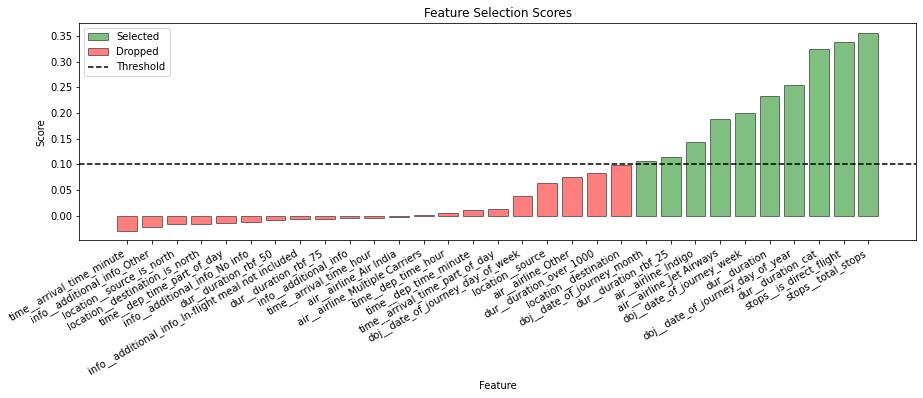

In [84]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that